## IMPORTING LIBARIRES:

In [2]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
! pip install seaborn
import seaborn as sns
import cv2

## DATA LOADING:

In [3]:
data_dir=r"D:\SEM-8\CODE\data"
acci=[]
for file in os.listdir(data_dir):
    acci+=[file]
print(acci)
print(len(acci))

['Accident', 'No Accident']
2


In [4]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [5]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## PREPROCESSING:

In [6]:
img_height,img_width=224,224
batch_size=20

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_generator = train_datagen.flow_from_directory(data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training')
test_generator = train_datagen.flow_from_directory(data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation')

Found 369 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


## APPLYING MOBILENET ALGORITHM:

In [8]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

## MODEL TRAINING:

In [9]:

model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist3=model2.fit(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
19/19 [==============================] - 41s 2s/step - loss: 0.8248 - accuracy: 0.6043 - precision: 0.5746 - recall: 0.5528 - sensitivity_at_specificity: 0.9295 - specificity_at_sensitivity: 0.9702 - val_loss: 2.3856 - val_accuracy: 0.0701 - val_precision: 0.3775 - val_recall: 0.5987 - val_sensitivity_at_specificity: 0.2229 - val_specificity_at_sensitivity: 0.3312
Epoch 2/20
19/19 [==============================] - 29s 1s/step - loss: 0.5373 - accuracy: 0.7290 - precision: 0.6842 - recall: 0.6341 - sensitivity_at_specificity: 0.9892 - specificity_at_sensitivity: 0.9702 - val_loss: 3.7183 - val_accuracy: 0.0446 - val_precision: 0.0904 - val_recall: 0.0955 - val_sensitivity_at_specificity: 0.0446 - val_specificity_at_sensitivity: 0.0382
Epoch 3/20
19/19 [==============================] - 30s 2s/step - loss: 0.3912 - accuracy: 0.8347 - precision: 0.7193 - recall: 0.6667 - sensitivity_at_specificity: 0.9892 - specificity_at_sensitivity: 0.9864 - val_loss: 1.8252 - val_accuracy: 

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall (Sensitivity)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


In [11]:
# Make predictions on the test dataset
y_pred = model2.predict(test_generator)  # Get the raw predictions


8/8 [==============================] - 3s 304ms/step


In [12]:
y_true = test_generator.classes  # Ground truth labels from test generator


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Convert raw predictions to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.95      0.82      0.88       150

    accuracy                           0.78       157
   macro avg       0.47      0.41      0.44       157
weighted avg       0.90      0.78      0.84       157



In [14]:
model2.evaluate(test_generator)

8/8 [==============================] - 3s 311ms/step - loss: 1.1757 - accuracy: 0.8344 - precision: 0.8261 - recall: 0.8471 - sensitivity_at_specificity: 0.8981 - specificity_at_sensitivity: 0.8917


[1.1757011413574219,
 0.8343949317932129,
 0.8260869383811951,
 0.8471337556838989,
 0.8980891704559326,
 0.8917197585105896]

## GRAPH:

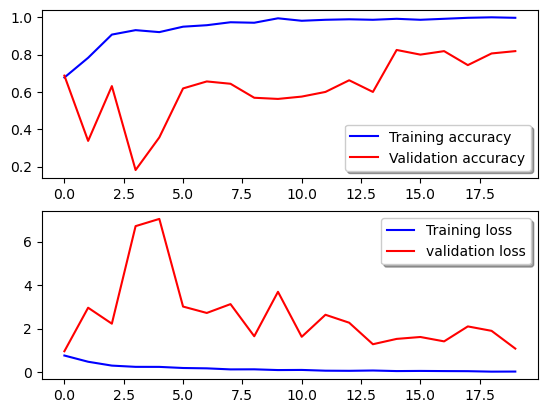

In [37]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist3.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist3.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist3.history['loss'], color='b', label="Training loss")
ax[1].plot(hist3.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

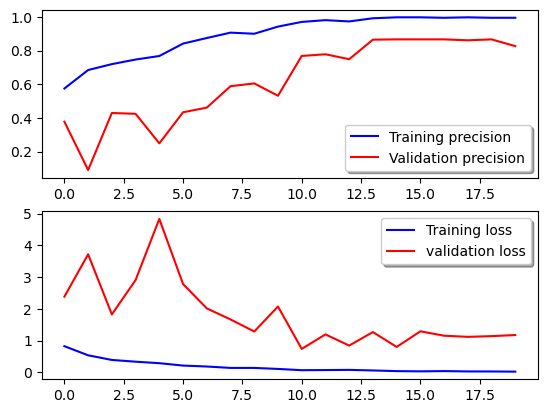

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist3.history['precision'], color='b', label="Training precision")
ax[0].plot(hist3.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist3.history['loss'], color='b', label="Training loss")
ax[1].plot(hist3.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

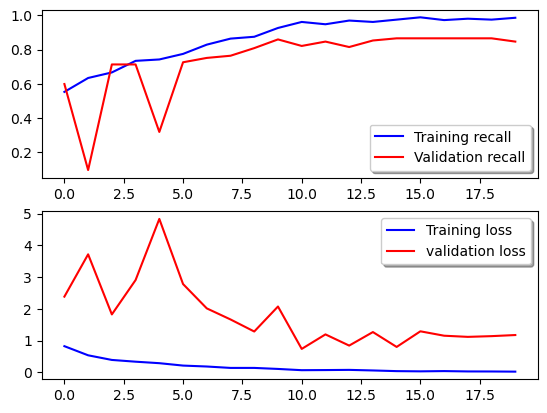

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist3.history['recall'], color='b', label="Training recall")
ax[0].plot(hist3.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist3.history['loss'], color='b', label="Training loss")
ax[1].plot(hist3.history['val_loss'], color='r', label="validation loss",)
legend = ax[1].legend(loc='best', shadow=True)

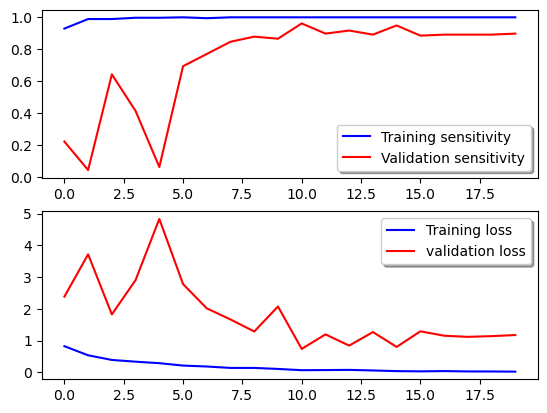

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist3.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist3.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist3.history['loss'], color='b', label="Training loss")
ax[1].plot(hist3.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [18]:
model2.evaluate(test_generator)
model2.save("confusion\MobileNet.h5")

8/8 [==============================] - 2s 283ms/step - loss: 1.1757 - accuracy: 0.8344 - precision: 0.8261 - recall: 0.8471 - sensitivity_at_specificity: 0.8981 - specificity_at_sensitivity: 0.8917


In [57]:
# Evaluate the model on the test generator
evaluation_results = model2.evaluate(test_generator)

# Print the evaluation results line by line
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])
print("Precision:", evaluation_results[2])
print("Recall:", evaluation_results[3])
print("Sensitivity at Specificity:", evaluation_results[4])
print("Specificity at Sensitivity:", evaluation_results[5])

# Save the model
model2.save("confusion/MobileNet.h5")


8/8 [==============================] - 3s 357ms/step - loss: 1.1881 - accuracy: 0.8250 - precision_2: 0.8250 - recall_2: 0.8250 - sensitivity_at_specificity_2: 0.8875 - specificity_at_sensitivity_2: 0.9937
Test Loss: 1.1880648136138916
Test Accuracy: 0.824999988079071
Precision: 0.824999988079071
Recall: 0.824999988079071
Sensitivity at Specificity: 0.887499988079071
Specificity at Sensitivity: 0.9937499761581421


In [20]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model2_predict = model2.predict_generator(test_generator,steps = nb_samples, verbose=2)

C:\Users\Dr.G.NITHIN-ESWAR\AppData\Local\Temp\ipykernel_528\723852190.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model2_predict = model2.predict_generator(test_generator,steps = nb_samples, verbose=2)


157/157 - 4s - 4s/epoch - 26ms/step


Confusion matrix, without normalization
[[  0   7]
 [ 27 123]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

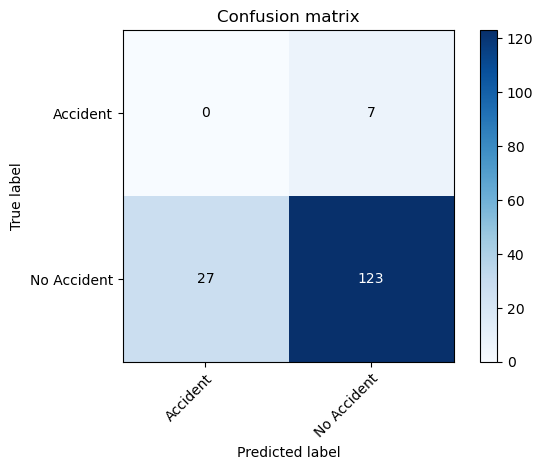

In [21]:
y_true = test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Accident', 'No Accident'],
                      title='Confusion matrix')